In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import torch
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
from datasets import dataset_utils
from datasets import sequence_aggregator
from explainability_analysis.visualization_functions import * 
from explainability_analysis.transformer_analysis import *
from explainability_analysis.crop_spectral_signature_analysis import * 
from explainability_analysis.classification_results_summarizer import * 

num_classes = 12
max_sequence_length = 144

def sort_obs_acq_dates_by_attention(model_root_path):
    
    predictions_path = os.path.join(model_root_path, "predictions")
    predicted_vs_true_results = pd.read_csv(os.path.join(predictions_path, "predicted_vs_true.csv"))
    attn_weights_path = os.path.join(predictions_path, "attn_weights", "postprocessed")
    
    total_temporal_attention = summarize_attention_weights_as_feature_embeddings(attn_weights_path, "layer_0", summary_fn="sum")
    attention_per_obs_acq_date = pd.concat([v for k,v in total_temporal_attention.items()])
    
    avg_attention_per_obs_acq_date = attention_per_obs_acq_date.mean().sort_values(ascending=False)
    avg_attention_per_obs_acq_date = avg_attention_per_obs_acq_date.to_frame()
    avg_attention_per_obs_acq_date.index.name="DATE"
    avg_attention_per_obs_acq_date.columns=["TOTAL_TEMPORAL_ATTENTION"]
    avg_attention_per_obs_acq_date.index = avg_attention_per_obs_acq_date.index.map(lambda x: "2018-{}-{}".format(x.split("-")[1], x.split("-")[0]))
    avg_attention_per_obs_acq_date.to_csv(os.path.join(attn_weights_path, "key_attention_dates.csv"))
    return avg_attention_per_obs_acq_date


def get_most_important_dates_for_percentage_scores(percentages, perc_dates_results, avg_attention_per_obs_acq_date_orig_model):
    
    result_dfs = []
    for perc in percentages:
        num_top_n_perc_dates = round((perc / 100.0) * max_sequence_length)
        top_n_perc_dates = avg_attention_per_obs_acq_date_orig_model.iloc[0:num_top_n_perc_dates].reset_index()
        top_n_perc_dates["PERCENTAGE"] = perc
        top_n_perc_dates["DATE"] = pd.to_datetime(top_n_perc_dates["DATE"]).apply(lambda date: date.strftime("%m-%d"))
        #top_n_perc_dates["DATE"] = top_n_perc_dates["DATE"].apply(lambda date: date[date.index("-") + 1:])
        top_n_perc_dates_with_accuracy = pd.merge(top_n_perc_dates, perc_dates_results, left_on="PERCENTAGE", right_on="Percent of observations")
        result_dfs.append(top_n_perc_dates_with_accuracy)
    
    return pd.concat(result_dfs, ignore_index=True).sort_values(by="DATE")

C:\Users\Ivica Obadic\PycharmProjects\EOExplainability


In [2]:
dataset_folder = "C:/Users/datasets/BavarianCrops/"
model_root_path = "C:/Users/results/{}_classes//right_padding/obs_aq_date/layers=1,heads=1,emb_dim=128/"
model_root_path = model_root_path.format(num_classes)

avg_attention_per_obs_acq_date_orig_model = sort_obs_acq_dates_by_attention(model_root_path)

Reading the attention weights for the 0-th test example
Reading the attention weights for the 1000-th test example
Reading the attention weights for the 2000-th test example
Reading the attention weights for the 3000-th test example
Reading the attention weights for the 4000-th test example
Reading the attention weights for the 5000-th test example
Reading the attention weights for the 6000-th test example
Reading the attention weights for the 7000-th test example
Reading the attention weights for the 8000-th test example
Reading the attention weights for the 9000-th test example
Reading the attention weights for the 10000-th test example
Reading the attention weights for the 11000-th test example
Reading the attention weights for the 12000-th test example
Reading the attention weights for the 13000-th test example
Reading the attention weights for the 14000-th test example
Reading the attention weights for the 15000-th test example
Reading the attention weights for the 16000-th test e

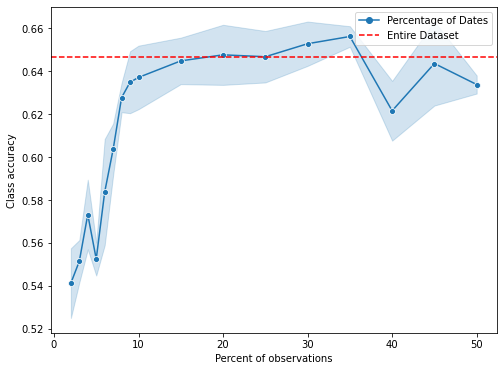

In [3]:
original_model_result = read_classification_results(model_root_path)
perc_dates_results = pd.read_csv(os.path.join(model_root_path, "perc_accuracy_results.csv"), index_col=0)

fig, axs = plt.subplots(figsize=(8, 6))
sns.lineplot(data=perc_dates_results, x="Percent of observations", y='Class accuracy', hue="Model type", style="Model type", ci="sd",ax=axs, markers=True, dashes=False)
axs.axhline(y=original_model_result[0], c='red', linestyle='dashed', label="Entire Dataset")
axs.legend(loc="upper right")

<AxesSubplot:xlabel='DATE', ylabel='Class accuracy'>

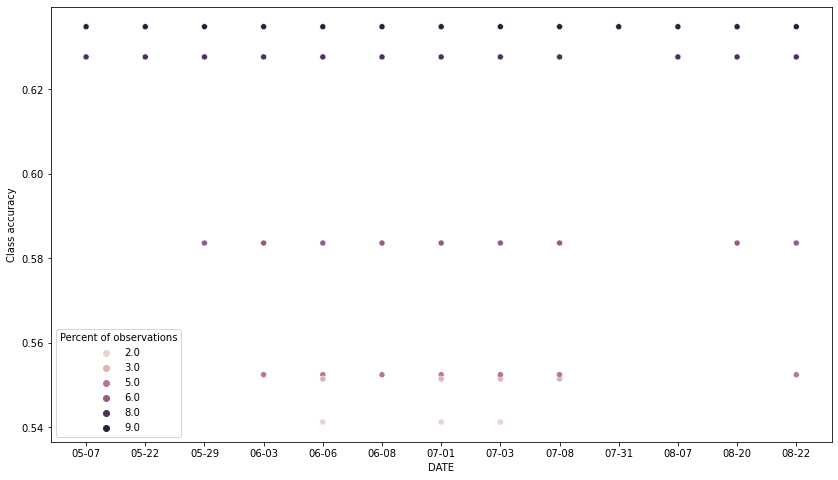

In [13]:
perc_dates_avg_results = perc_dates_results.groupby(["Percent of observations"]).agg("mean").reset_index()
most_important_dates_for_percentage_scores = get_most_important_dates_for_percentage_scores([2, 3, 5, 6, 7, 8, 9], perc_dates_avg_results, avg_attention_per_obs_acq_date_orig_model)
fig, axs = plt.subplots(figsize=(14, 8))
sns.scatterplot(data=most_important_dates_for_percentage_scores, x="DATE", y='Class accuracy', hue="Percent of observations", ax=axs)